In [1]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pathlib
import pickle
from PIL import Image, ImageDraw
import sys
from tqdm import tqdm
from types import SimpleNamespace
from torch.utils.data import DataLoader

from frameworks.pytorch.datasets.images_group_dataset import ImagesGroupDataset
from frameworks.opencv.overlap_finder import BatchOverlapFinder, RANSAC_MatrixFinder, batch_homographies

from extern.superpoints_utils import SuperPointFrontend
from extern.superpoints_utils import apply_net_eval as apply_superpoints_eval


plt.rcParams['figure.figsize'] = [25, 15] 

BGR_BLUE = (255, 0, 0)
BGR_YELLOW = (0, 255, 255)
BGR_HALF_GREEN = (0, 128, 0)

def color_mask(mask):
    def color_cls(mask, cls_, color):
        mask_b = (mask == cls_).astype(np.uint8) * 255
        mask_c = cv2.cvtColor(mask_b, cv2.COLOR_GRAY2BGR)
        mask_c[mask_b == 255] = color
        return mask_c
    
    mask_c = cv2.addWeighted(color_cls(mask, 1, BGR_BLUE), 1, color_cls(mask, 2, BGR_YELLOW), 1, 0)
    mask_c = cv2.addWeighted(mask_c, 1, color_cls(mask, 3, BGR_HALF_GREEN), 1, 0)
    return mask_c


In [2]:

#list_path = './data_lists/platges2021_all.json'
#list_path = './data_lists/platges2022_all.json'
list_path = './data_lists/platges2022_concept.json'
data_root = ''
downsample = 4

#ann_path = '/mnt/c/Users/Ignasi/Downloads/platgesbcn2021/'
ann_path = '/mnt/c/Users/Ignasi/Downloads/FOTOS_BCN_2022-04-06/panorama_stiching/masks/'

dataset = ImagesGroupDataset(json_path=list_path, data_root=data_root, downsample=downsample, read_flag=cv2.IMREAD_COLOR)
def my_collate(x): # <- x is a batch like [dataset[i] for i in batched_indices]
    return x # <- do not transform imgs to tensor
dataloader = DataLoader(dataset, collate_fn=my_collate)

In [5]:
for batch in dataloader:
    for group in batch: # batch is list of (img, path) elements
        group_of_imgs, pathes = tuple(zip(*list(group)))
        
        break
    break

group_of_masks = []
    
for path in pathes:
    with open(f'{ann_path}/{os.path.basename(path)[:-4]}.segments.pkl', 'rb') as f:
        mask = pickle.load(f, encoding='latin1')
        mask = cv2.resize(mask, None, fx=1/downsample, fy=1/downsample, interpolation=cv2.INTER_NEAREST)
        if True:
            mask[mask == 1] = 4
            mask[mask == 2] = 1
            mask[mask == 4] = 2
    group_of_masks.append(mask)
    
group_of_imgs = group_of_imgs[::-1]
group_of_masks = group_of_masks[::-1]

img = group_of_imgs[0]
mask = group_of_masks[0]

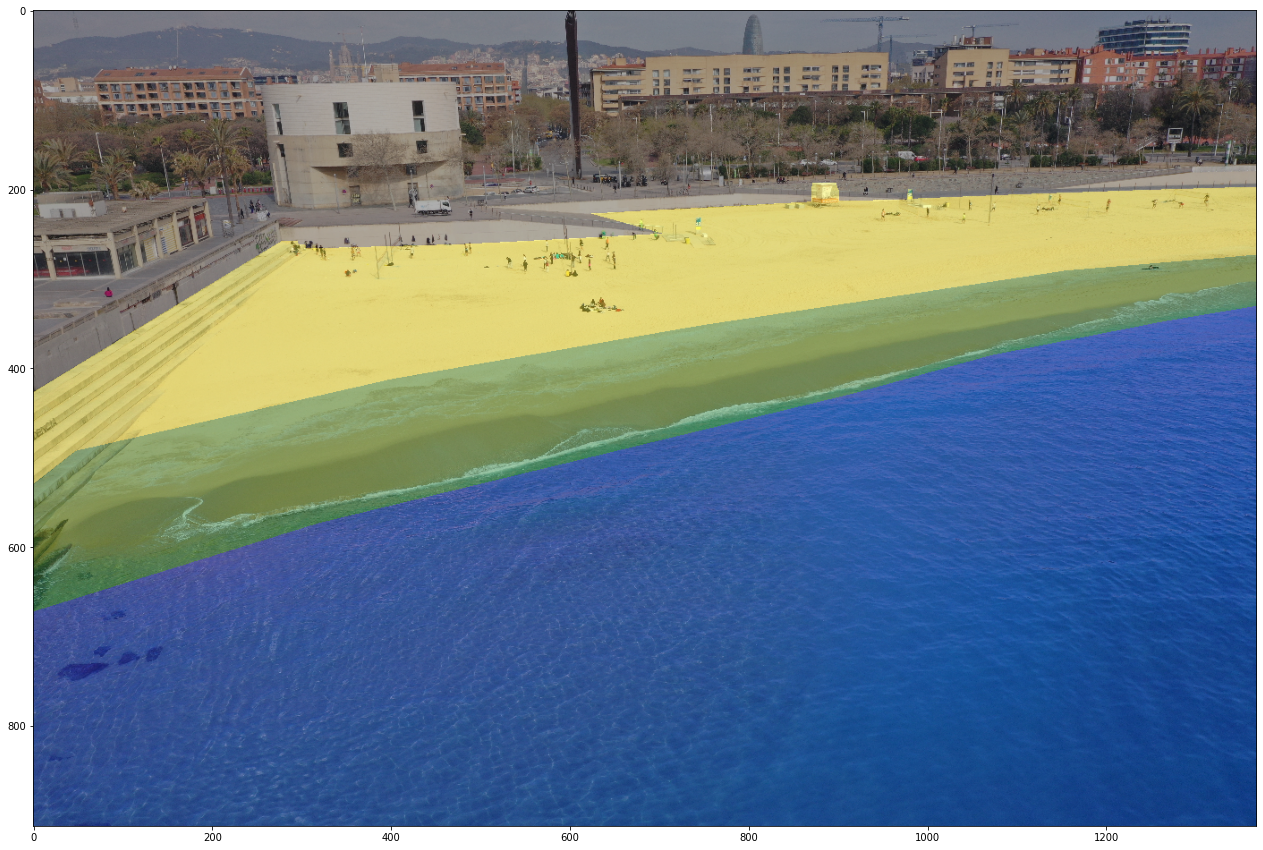

In [6]:
blend_img = cv2.cvtColor(color_mask(mask), cv2.COLOR_BGR2RGB)
blend_img = cv2.addWeighted(img, 0.7, blend_img, 0.3, 0)

plt.imshow(blend_img)
plt.show()

In [18]:
weights_path = 'extern/SuperPointPretrainedNetwork/superpoint_v1.pth'
radi = 5 # Radius of points

if True:
    descriptor = cv2.SIFT_create()
    point_finder_descriptor = lambda img : descriptor.detectAndCompute(img, None)
elif True:
    model = SuperPointFrontend(weights_path=weights_path, nms_dist=4, conf_thresh=0.015, nn_thresh=0.7, cuda=False)
    point_finder_descriptor = lambda img : apply_superpoints_eval(model, cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), radi)

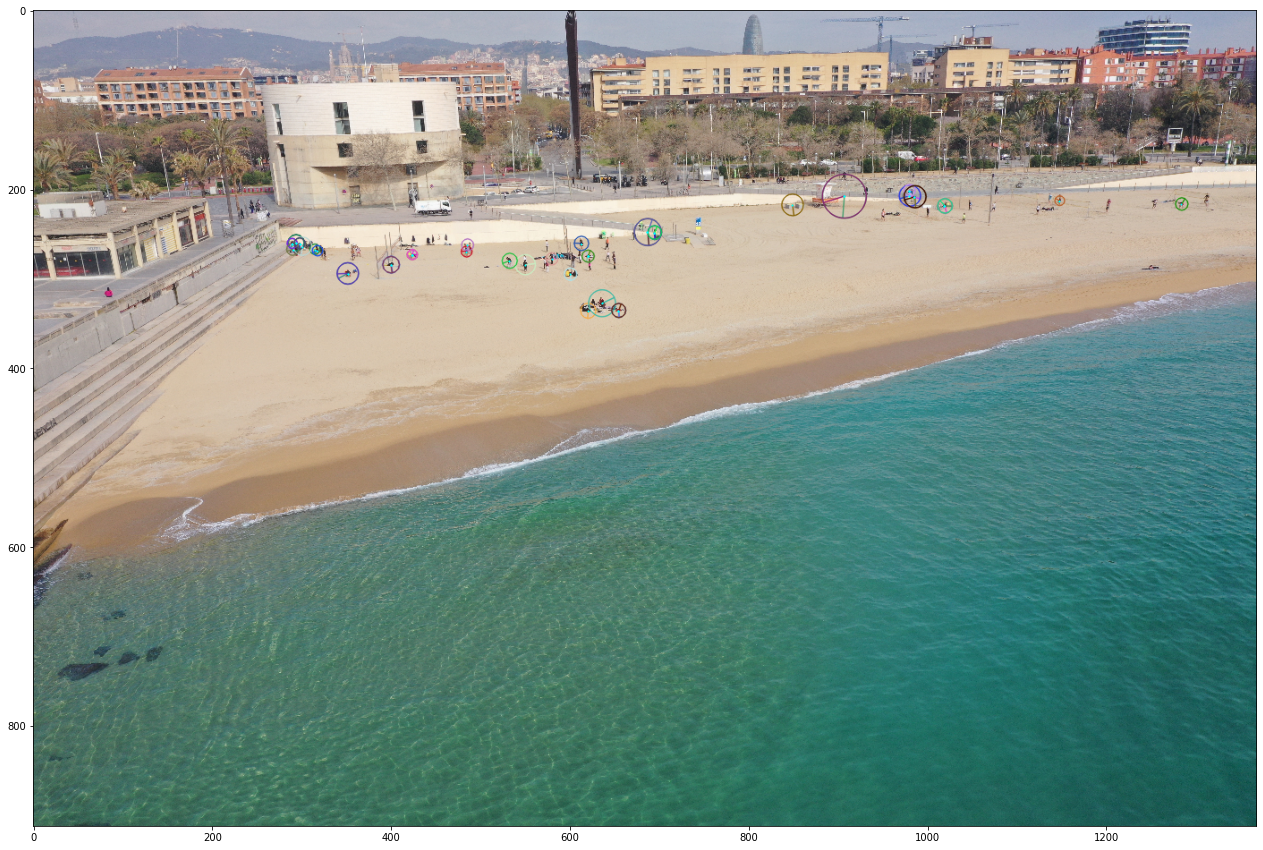

In [46]:

MAX_NUM_KEYPOINTS = 50 # None : unlimited, N : limited to N, -N : remove last N
SIZE_INCREASE = 6

input_img = img.copy()

input_img[(mask == 0) | (mask == 1) | ((mask == 3)), :] = 0

kp, des = point_finder_descriptor(input_img)

# best keypoints by score
kp = sorted(kp, key=lambda x : x.response, reverse=True)[:MAX_NUM_KEYPOINTS]

# From KeyPoint object to points
#pts = np.array([k.pt for k in kp])
pts = cv2.KeyPoint.convert(kp)

if len(kp) <= 36 : print(',  '.join([f'{k.response:.2}' for k in kp]))

#print(',  '.join([f'{k.size:.2}' for k in kp]))
for k in kp : k.size = k.size * SIZE_INCREASE

output = np.zeros_like(img)
output = cv2.drawKeypoints(img, kp , output, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.plot(pts[:, 0], pts[:, 1], color='cyan', marker='o', linestyle='None', markersize=1)
plt.imshow(output)
plt.show()

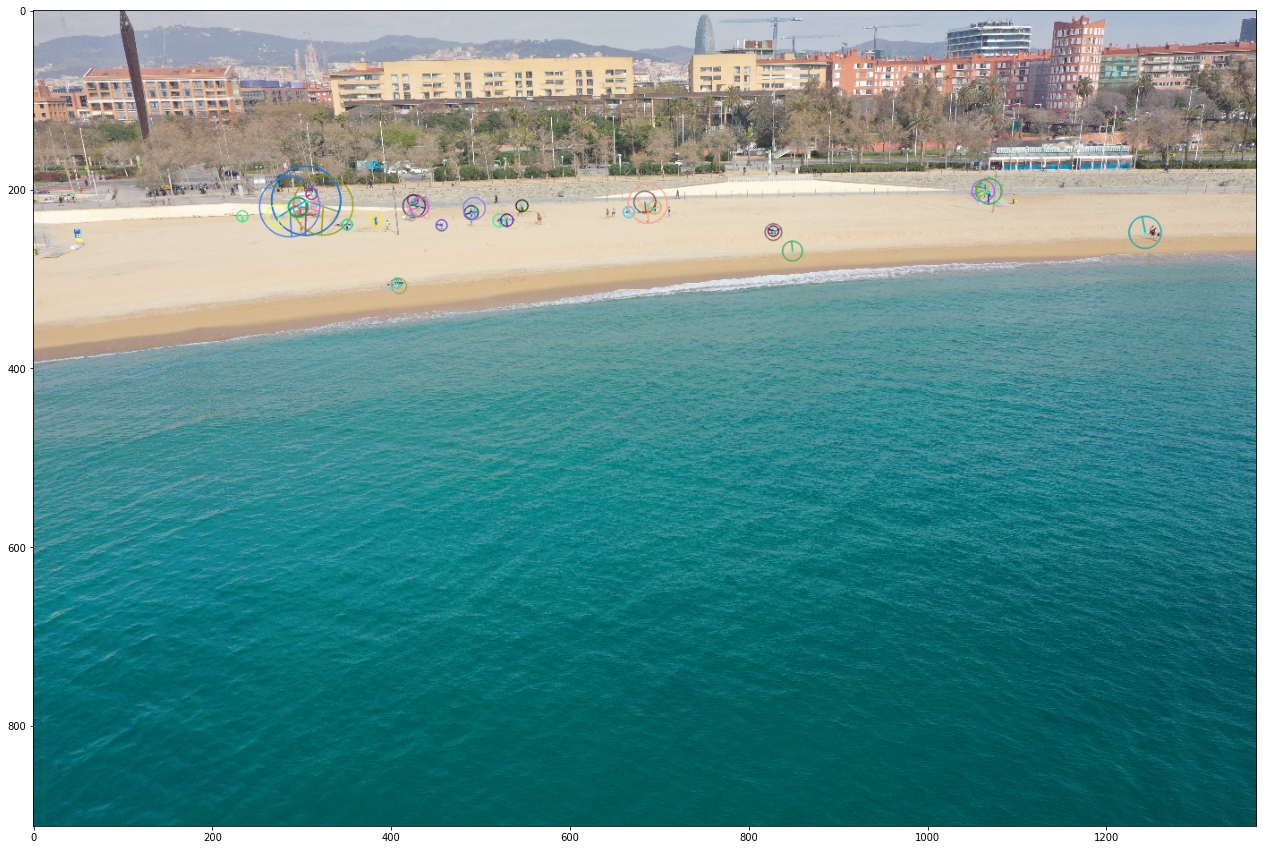

In [47]:

img2 = group_of_imgs[1]
mask2 = group_of_masks[1]


input_img2 = img2.copy()

input_img2[(mask2 == 0) | (mask2 == 1) | ((mask2 == 3)), :] = 0

kp2, des2 = point_finder_descriptor(input_img2)

# best keypoints by score
kp2 = sorted(kp2, key=lambda x : x.response, reverse=True)[:MAX_NUM_KEYPOINTS]

# From KeyPoint object to points
#pts = np.array([k.pt for k in kp])
pts2 = cv2.KeyPoint.convert(kp2)

if len(kp2) <= 36 : print(',  '.join([f'{k.response:.2}' for k in kp2]))

#print(',  '.join([f'{k.size:.2}' for k in kp]))
for k in kp2 : k.size = k.size * SIZE_INCREASE

output2 = np.zeros_like(img2)
output2 = cv2.drawKeypoints(img2, kp2 , output2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.plot(pts2[:, 0], pts2[:, 1], color='cyan', marker='o', linestyle='None', markersize=1)
plt.imshow(output2)
plt.show()